In [19]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np


In [20]:
training_file_path = 'balabit_features_training.csv'
data = pd.read_csv(training_file_path)

In [21]:
testing_file_path = 'balabit_features_test.csv'
test_data = pd.read_csv(testing_file_path)


In [22]:
selected_columns = [
    'mean_v', 'sd_v',  'mean_vx', 'sd_vx', 
    'mean_vy', 'sd_vy',  'mean_a', 'sd_a', 
    'mean_jerk', 'sd_jerk',  'direction_of_movement'
]


In [23]:
train_cleaned = data.dropna(subset=selected_columns)[selected_columns]
test_cleaned = test_data.dropna(subset=selected_columns)[selected_columns]

In [24]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_cleaned)
test_scaled = scaler.transform(test_cleaned)
train_scaled

array([[ 0.24748317,  0.13932546, -0.29748414, ...,  0.47233557,
         0.19074132, -0.19525066],
       [-0.45783925, -0.27796936,  0.00574336, ..., -0.18361633,
        -0.1777255 , -0.61864019],
       [ 0.15394662, -0.01692433,  0.92128938, ...,  0.20142674,
        -0.00220646,  1.49830744],
       ...,
       [ 0.0868923 , -0.05817208, -1.00098989, ..., -0.04814379,
         0.0182593 ,  0.22813886],
       [-0.12608699, -0.21584273, -0.38050371, ..., -0.09954099,
        -0.02530537,  0.65152839],
       [-0.11613796, -0.19586087,  0.74881927, ..., -0.09451473,
        -0.06163343, -1.46541924]])

In [25]:
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_scaled)
test_pca = pca.transform(test_scaled)
train_pca

array([[ 0.71704342,  0.06224306,  0.31600614,  0.06508479,  0.2109764 ,
        -0.26733139],
       [-0.67328701,  0.7169955 ,  0.06408646,  0.20407284, -0.00336461,
        -0.01553484],
       [-0.1688529 , -1.81848659, -0.44844049, -0.85267028,  0.47233715,
        -0.21120694],
       ...,
       [-0.04527816, -0.69200526,  0.7612666 ,  0.67334267, -0.21553452,
        -0.23456872],
       [-0.39195808, -0.87202493,  0.38957121,  0.09529302, -0.20576677,
        -0.15042591],
       [-0.4772288 ,  1.17802599, -0.61268019,  0.4271986 ,  0.82129495,
        -0.14909337]])

In [26]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train_pca)


KMeans(n_clusters=10, random_state=42)

In [27]:
test_labels = kmeans.predict(test_pca)

In [28]:
distances = np.linalg.norm(test_pca - kmeans.cluster_centers_[test_labels], axis=1)

In [29]:
test_data['cluster'] = test_labels
test_data['distance_to_center'] = distances

In [30]:
test_data.to_csv('clustered_testing_data_fixed_10_clusters.csv', index=False)

In [31]:
print(test_data.head())

   type_of_action  traveled_distance_pixel  elapsed_time  \
0               3               357.084960         1.170   
1               3               369.966397         1.591   
2               3               993.948298         6.849   
3               1              1610.385871         4.431   
4               3               305.408959         0.780   

   direction_of_movement  straightness  num_points  sum_of_angles  mean_curv  \
0                      7      0.519784          10       3.697425  -0.090787   
1                      6      0.606582          14       5.039419   0.079153   
2                      1      0.787196          19      -0.545368   0.209308   
3                      4      0.409789          27     -24.136770   0.207996   
4                      2      0.954445           7      12.897938   0.011900   

    sd_curv  max_curv  ...      max_jerk      min_jerk  a_beg_time  class  \
0  0.267935  0.177068  ...  6.351428e+04  -64410.62468       0.218     12   
1  0

In [33]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=10, random_state=42)
gmm.fit(train_pca)
gmm_labels = gmm.predict(test_pca)
gmm_probabilities = gmm.predict_proba(test_pca)

# Add GMM labels and probability scores to the test dataset
test_data['gmm_cluster'] = gmm_labels
test_data['gmm_probabilities'] = gmm_probabilities.max(axis=1)  # Highest probability for each point

# Saving GMM-based results (optional)
test_data.to_csv('gmm_clustered_testing_data_fixed_10_clusters.csv', index=False)

# Display the first few rows with GMM results
print(test_data.head())

   type_of_action  traveled_distance_pixel  elapsed_time  \
0               3               357.084960         1.170   
1               3               369.966397         1.591   
2               3               993.948298         6.849   
3               1              1610.385871         4.431   
4               3               305.408959         0.780   

   direction_of_movement  straightness  num_points  sum_of_angles  mean_curv  \
0                      7      0.519784          10       3.697425  -0.090787   
1                      6      0.606582          14       5.039419   0.079153   
2                      1      0.787196          19      -0.545368   0.209308   
3                      4      0.409789          27     -24.136770   0.207996   
4                      2      0.954445           7      12.897938   0.011900   

    sd_curv  max_curv  ...  a_beg_time  class    session  n_from  n_to  \
0  0.267935  0.177068  ...       0.218     12  126772600       5    15   
1  0.29854

In [36]:
# The normal user data point
normal_user_data_point = {
    'mean_v': 634.152499,
    'sd_v': 1061.6933,
#     'max_v': 5162.3637,
#     'min_v': 2.3889,
    'mean_vx': -133.4056,
    'sd_vx': 907.0929,
#     'max_vx': 3300.0,
#     'min_vx': -5100.0,
    'mean_vy': -31.9546,
    'sd_vy': 834.9679,
#     'max_vy': 1900.0,
#     'min_vy': -4900.0,
    'mean_a': 26692.5428,
    'sd_a': 87552.8379,
#     'max_a': 435648.1302,
#     'min_a': -39709.2721,
    'mean_jerk': 2782076.0583,
    'sd_jerk': 9098248.5988,
#     'max_jerk': 43107871.5131,
#     'min_jerk': -4296965.0754,
    'direction_of_movement': 45
}

# Convert the data point into a DataFrame for easier manipulation
user_data_df = pd.DataFrame([normal_user_data_point])

# Standardize the new data point using the same scaler that was used for training data
user_scaled = scaler.transform(user_data_df)

# Apply PCA to the scaled data using the same PCA model fitted on the training data
user_pca = pca.transform(user_scaled)

# Predict the cluster for the new data point using the trained KMeans model
user_cluster = kmeans.predict(user_pca)

# Calculate the distance from the new data point to its assigned cluster center
user_distance = np.linalg.norm(user_pca - kmeans.cluster_centers_[user_cluster], axis=1)

# Calculate the distance from the new data point to all cluster centers
all_distances = np.linalg.norm(user_pca - kmeans.cluster_centers_, axis=1)

# Output the cluster assignment, distance to assigned cluster, and distances to all clusters
print(f"Cluster assignment for the normal user data point: {user_cluster[0]}")
print(f"Distance to the assigned cluster center: {user_distance[0]}")
print(f"Distances to all cluster centers: {all_distances}")


Cluster assignment for the normal user data point: 8
Distance to the assigned cluster center: 16.517607984247512
Distances to all cluster centers: [17.56100347 87.78374494 44.13136083 22.8211211  37.14918254 40.81735345
 18.73889561 17.74302744 16.51760798 36.78890201]


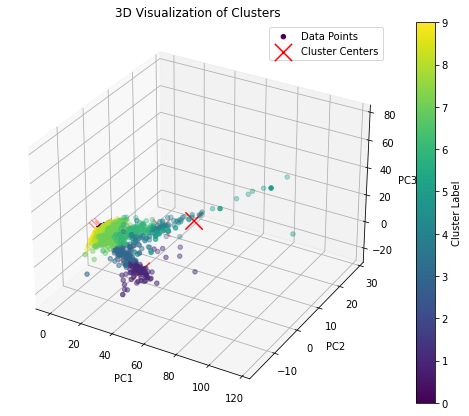

In [37]:
# Importing necessary libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce to 3 dimensions for visualization
pca_3d = PCA(n_components=3)
train_pca_3d = pca_3d.fit_transform(train_scaled)

# Fit the KMeans model on the 3D PCA-transformed data
kmeans_3d = KMeans(n_clusters=10, random_state=42)
kmeans_3d.fit(train_pca_3d)

# Predict the clusters
train_labels_3d = kmeans_3d.predict(train_pca_3d)

# Create a 3D scatter plot to visualize the clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with each cluster in a different color
scatter = ax.scatter(train_pca_3d[:, 0], train_pca_3d[:, 1], train_pca_3d[:, 2], 
                     c=train_labels_3d, cmap='viridis', marker='o')

# Adding cluster centers for KMeans
centers_3d = kmeans_3d.cluster_centers_
ax.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2], 
           s=300, c='red', marker='x', label='Cluster Centers')

# Labeling the axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Title and legend
plt.title('3D Visualization of Clusters')
plt.legend(['Data Points', 'Cluster Centers'])

# Show color bar (optional)
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')

# Show the plot
plt.show()


In [40]:
import numpy as np
import pandas as pd

# Bot data point
bot_data_point_1 = {
    'mean_v': 165.42699321065575, 'sd_v': 77.65849707675503,
    'mean_vx': 6.3436535831151035, 'sd_vx': 121.20039495852168,
#     'max_vx': 309.9707491601623, 'min_vx': -236.28644623528032,
    'mean_vy': 0.1577048385253537, 'sd_vy': 139.48382600695857,
#     'max_vy': 422.4722888631386, 'min_vy': -363.25333579789077,
    'mean_a': 234.95573240971243, 'sd_a': 236.79599399806543,
#     'max_a': 506.3764087624721, 'min_a': 0.0,
    'mean_jerk': 299.4792865228851, 'sd_jerk': 180.31654154973305,
#     'max_jerk': 821.346406537999, 'min_jerk': 0.0,
    'direction_of_movement': -0.41517954114486444
}

# Convert the data point into a DataFrame for easier manipulation
user_data_df = pd.DataFrame([bot_data_point_1])

# Step 1: Standardize the new data point using the same scaler that was used for training data
user_scaled = scaler.transform(user_data_df)

# Step 2: Apply PCA to the scaled data using the same PCA model fitted on the training data
user_pca = pca.transform(user_scaled)

# Step 3: Predict the cluster for the new data point using the trained KMeans model
user_cluster = kmeans.predict(user_pca)

user_distance = np.linalg.norm(user_pca - kmeans.cluster_centers_[user_cluster], axis=1)

# Step 5: Calculate the distance from the new data point to all cluster centers
all_distances = np.linalg.norm(user_pca - kmeans.cluster_centers_, axis=1)

# Output the cluster assignment, distance to assigned cluster, and distances to all clusters
print(f"Cluster assignment for the bot user data point: {user_cluster[0]}")
print(f"Distance to the assigned cluster center: {user_distance[0]}")
print(f"Distances to all cluster centers: {all_distances}")


Cluster assignment for the bot user data point: 6
Distance to the assigned cluster center: 0.7883580755689458
Distances to all cluster centers: [ 1.82570683 87.26372182 41.37315807 15.89516061 34.00232932 38.26978011
  0.78835808  4.81145239  2.82857813 33.52753541]


In [42]:
# Assuming you have already performed KMeans clustering and have cluster labels
import pandas as pd

# Convert KMeans cluster labels into a DataFrame for easier counting
kmeans_cluster_labels = pd.Series(test_labels)

# Count the number of points in each cluster
kmeans_cluster_counts = kmeans_cluster_labels.value_counts().sort_index()

# Display the result
print("Number of points in each KMeans cluster:")
print(kmeans_cluster_counts)


Number of points in each KMeans cluster:
0    10927
1        5
2       14
3      199
4       32
5       27
6    14378
7     1999
8    13512
9       48
Name: count, dtype: int64


In [43]:
# Assuming you have GMM's most probable cluster assignments (gmm_most_probable_cluster)
gmm_cluster_labels = pd.Series(gmm_most_probable_cluster)

# Count the number of points in each GMM cluster
gmm_cluster_counts = gmm_cluster_labels.value_counts().sort_index()

# Display the result
print("Number of points in each GMM cluster (most probable):")
print(gmm_cluster_counts)


NameError: name 'gmm_most_probable_cluster' is not defined

In [44]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming your dataset is loaded as `data` and the relevant columns are selected
# selected_columns = ['mean_v', 'sd_v', ..., 'direction_of_movement']
features_df = data[selected_columns]

# Step 1: Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

# Step 2: Apply PCA to reduce dimensionality for clustering
pca = PCA(n_components=3)  # Reduce to 3 components for easier clustering and visualization
features_pca = pca.fit_transform(features_scaled)

# Step 3: Apply KMeans Clustering (with 10 clusters)
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans_labels = kmeans.fit_predict(features_pca)

# Step 4: Convert KMeans cluster labels into a DataFrame for easier counting
kmeans_cluster_labels = pd.Series(kmeans_labels)

# Step 5: Count the number of points in each cluster
kmeans_cluster_counts = kmeans_cluster_labels.value_counts().sort_index()

# Step 6: Display the result
print("Number of points in each KMeans cluster:")
print(kmeans_cluster_counts)


Number of points in each KMeans cluster:
0    16889
1       79
2    21774
3      103
4       70
5       25
6      113
7      360
8     2458
9    19034
Name: count, dtype: int64
